# Introduction
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) was suscribed ('yes') or not ('no') subscribed. For the original dataset, you can visit [here](https://www.kaggle.com/henriqueyamahata/bank-marketing). 

For this project, I wanted to create and train a classifier that could identify whether a client would subscribe to a term deposit prior to the phone call being completed.

This project was completed for USC's ITP 449 Applications of Machine Learning class. 

# Attributes in Dataset
### Bank client data:
* Age (numeric)
* Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
* Marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
* Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
  * Note: Portuguese basic education school spans nin years, from 1st-4th, 5th-6th and 7th-9th. This is what basic.4y etc refer to. 
* Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
* Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
* Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

### Related with the last contact of the current campaign:
* Contact: contact communication type (categorical:
'cellular','telephone')
* Month: last contact month of year (categorical: 'jan', 'feb', 'mar',
…, 'nov', 'dec')
* Dayofweek: last contact day of the week (categorical:
'mon','tue','wed','thu','fri')
* Duration: last contact duration, in seconds (numeric). 
  * Important note: this attribute highly affects the output target (e.g., if
duration=0 then y='no'). Yet, the duration is not known before a call
is performed. Also, after the end of the call y is obviously known.
Thus, this input should only be included for benchmark purposes and
should be discarded if the intention is to have a realistic
predictive model.

### Other attributes:
* Campaign: number of contacts performed during this campaign and for
this client (numeric, includes last contact)
* Pdays: number of days that passed by after the client was last
contacted from a previous campaign (numeric; 999 means client was not
previously contacted)
* Previous: number of contacts performed before this campaign and for
this client (numeric)
* Poutcome: outcome of the previous marketing campaign (categorical:
'failure','nonexistent','success')

### Social and economic context attributes:
These were the values for the day that the call was made. 
* Emp.var.rate: employment variation rate - quarterly indicator
(numeric)
* Cons.price.idx: consumer price index - monthly indicator (numeric)
* Cons.conf.idx: consumer confidence index - monthly indicator
(numeric)
* Euribor3m: euribor 3 month rate - daily indicator (numeric)
* Nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
* y - has the client subscribed a term deposit? (binary: 'yes', 'no')

# Import Libraries

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

Read the csv file using Pandas. Store the output into a dataframe named df.

In [210]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_handle = drive.CreateFile({'id': '1v5qwjDh-Qbl6RaMvciB0dcBrPOYrsAmu'}) # to get the ID, go to your google drive, right click on the file and click on get link. Copy the id in the URL
file_handle.GetContentFile('bank-additional-full.csv')

In [212]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('bank-additional-full.csv', sep=';')
print(df)

       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campa

# Data Wrangling

In [213]:
print(df.shape)
print(df.columns.values)
print(df.isnull().sum())

# This appears to be a full dataset with no blank values. 

(41188, 21)
['age' 'job' 'marital' 'education' 'default' 'housing' 'loan' 'contact'
 'month' 'day_of_week' 'duration' 'campaign' 'pdays' 'previous' 'poutcome'
 'emp.var.rate' 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed'
 'y']
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


The "duration" column is removed. Data from the "duration" column is only collected after the call ends, and the outcome variable "y" is known when the call ends. As a result, this attribute is highly correlated to outcome "y" (also because if duration=0, then y will always be 'no'). 

In [214]:
del df['duration']
print(df.head())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0   may         mon         1    999         0  nonexistent           1.1   
1   may         mon         1    999         0  nonexistent           1.1   
2   may         mon         1    999         0  nonexistent           1.1   
3   may         mon         1    999         0  nonexistent           1.1   
4   may         mon         1    999         0  nonexistent           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994

I would like to see all unique values that are listed in each of the columns. It appears that some of the columns contain data that are related to one another (for example, "month" and "day_of_week" appear to have related information). 

In [215]:
for col in df: 
  print(df[col].unique())

[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
['married' 'single' 'divorced' 'unknown']
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
['no' 'unknown' 'yes']
['no' 'yes' 'unknown']
['no' 'yes' 'unknown']
['telephone' 'cellular']
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
['mon' 'tue' 'wed' 'thu' 'fri']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]
[999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]
[0 1 2 3 4 5 6 7]
['nonexi

The unique values of the columns do indicate that the data can be further grouped (see Attributes section above, as these will be how I group the data further and the reasoning why). Note that the socioeconomic attributes are contingent upon the day that the call was made (aka the last_campaign dataset). 

In [216]:
client = df.iloc[:, 0:7] # client personal info
print(client.head())

last_campaign = df.iloc[:, 7:10] # info related to the day they were called
print(last_campaign.head()) 

other = df[['campaign', 'pdays', 'previous', 'poutcome']] # info related to if they were previously called
print(other.head())

se = df[['month', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']] # info related to the current socioeconomic attributes of the day they were called
print(se.head())

   age        job  marital    education  default housing loan
0   56  housemaid  married     basic.4y       no      no   no
1   57   services  married  high.school  unknown      no   no
2   37   services  married  high.school       no     yes   no
3   40     admin.  married     basic.6y       no      no   no
4   56   services  married  high.school       no      no  yes
     contact month day_of_week
0  telephone   may         mon
1  telephone   may         mon
2  telephone   may         mon
3  telephone   may         mon
4  telephone   may         mon
   campaign  pdays  previous     poutcome
0         1    999         0  nonexistent
1         1    999         0  nonexistent
2         1    999         0  nonexistent
3         1    999         0  nonexistent
4         1    999         0  nonexistent
  month  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed
0   may           1.1          93.994          -36.4      4.857       5191.0
1   may           1.1          93.99

# Data Exploration

## Bank client data, using client dataframe

### Exploring Age: 

In [217]:
client['age'].describe()

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

Text(0.5, 1.0, 'Age Count Distribution')

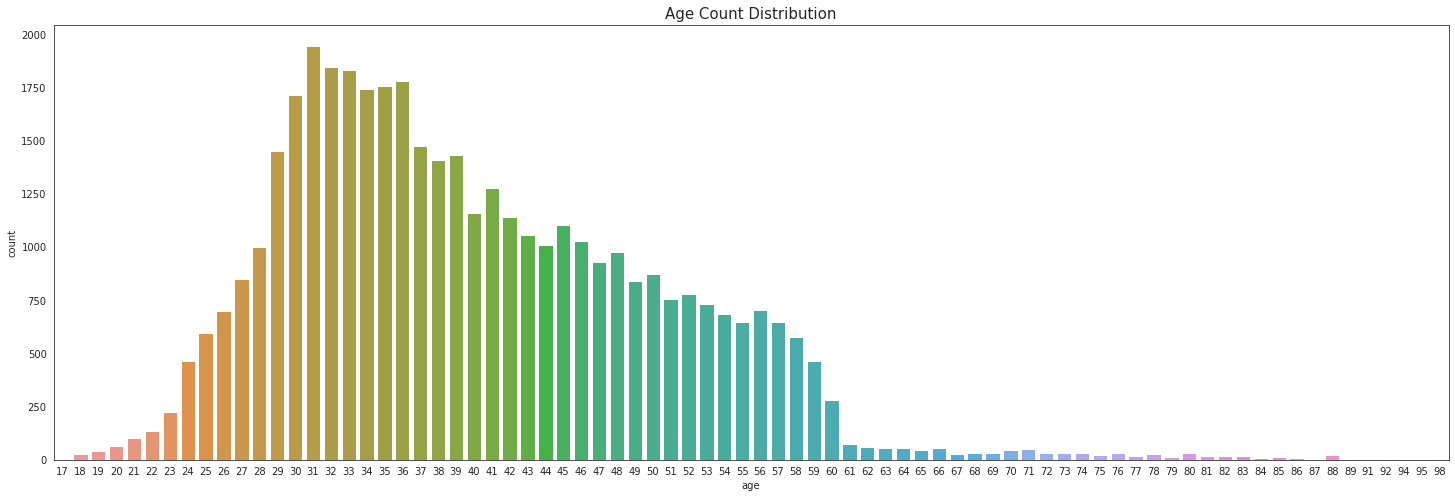

In [218]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 8)
sns.countplot(x='age', data=client)
ax.set_title('Age Count Distribution', fontsize=15)

There appears to be outliers in age, but a better way to see this is through boxplots. Furthermore, we need to see if age data has Gaussian distribution (to pick the best outlier removal method)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Ages')

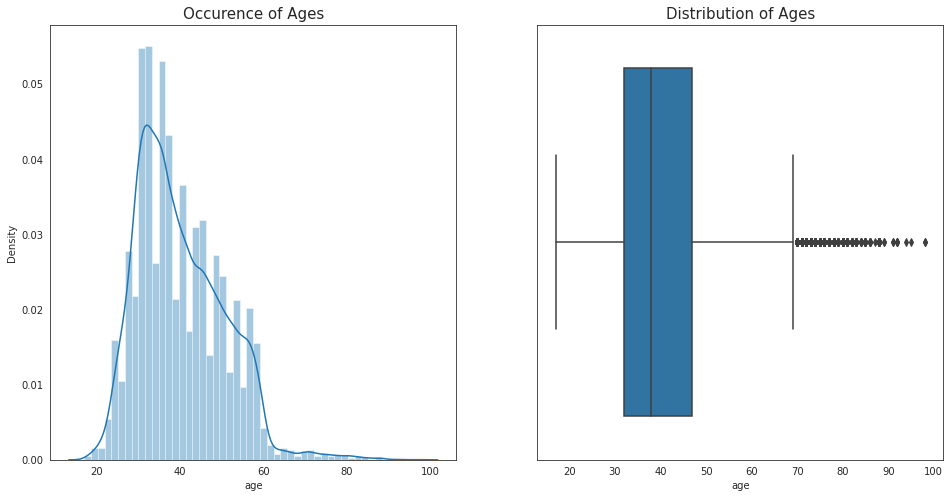

In [219]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))

sns.distplot(client['age'], ax=ax1)
ax1.set_title('Occurence of Ages', fontsize=15)

sns.boxplot(x='age', data=client, ax=ax2)
ax2.set_title('Distribution of Ages', fontsize=15)

From the boxplot, we can see that there appears to be outliers >70 years of age. The displot shows that age is a non-Gaussian distribution. The best way to remove these outliers is to use the interquartile range method (IQR). 

In [220]:
# calculate the IQR
q25, q75 = client['age'].quantile(q=0.25), client['age'].quantile(q=0.75)
iqr = q75-q25

# calculate outlier cutoff 
cutoff = iqr*1.5 
lower, upper = q25 - cutoff, q75 + cutoff
print(lower, upper)

9.5 69.5


Here, the outliers are any age above 69.5. It may also help to look at the dispersion of age. 

In [221]:
print('Number of outliers: ', client[client['age'] > 69.6]['age'].count())
print('Number of clients: ', len(client))
print('Percentage of outliers: ', (client[client['age'] > 69.6]['age'].count())/len(client)*100, '%')

Number of outliers:  469
Number of clients:  41188
Percentage of outliers:  1.1386811692726035 %


In [222]:
print('mean age: ', client['age'].mean())
print('std of age: ', client['age'].std())
print('CV of age: ', client['age'].std() / client['age'].mean() * 100)

mean age:  40.02406040594348
std of age:  10.421249980934235
CV of age:  26.037463154004993


At this point, it is too early to tell if age is directly related to the y outcome. Since the dispersion of age is high, the higher age ranges might just be a natural representation of the population. Rather than deleting these outliers, I will keep them in mind when I pick and run a model later. 

### Exploring categorical variables of the client dataframe

Text(0.5, 1.0, 'Job Distribution')

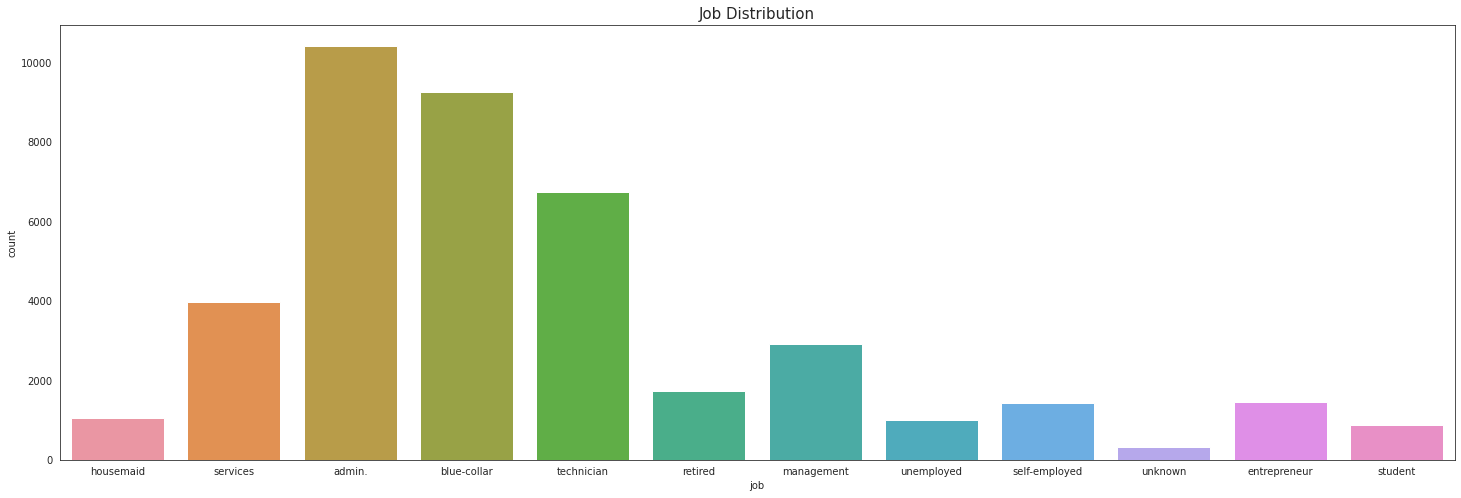

In [223]:
# jobs distribution
fig, ax = plt.subplots()
fig.set_size_inches(25, 8)
sns.countplot(x='job', data=client)
ax.set_title('Job Distribution', fontsize=15)

In [224]:
# jobs collinearity -- the "self-employed" and "entreprenuer" title are often used interchangeably. Here, I wanted to check the colinearity between these two variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor 

dummy_client = pd.get_dummies(client)
dummy_job = dummy_client[['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
 'job_management', 'job_retired', 'job_self-employed', 'job_services',
 'job_student', 'job_technician', 'job_unemployed', 'job_unknown']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = dummy_job.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(dummy_job.values, i)
                          for i in range(len(dummy_job.columns))]

print(vif_data)

# Here, all job attributes hab low values of VIF, indicating that these variables are not highly correlated. 

              feature       VIF
0          job_admin.  0.017463
1     job_blue-collar  0.004106
2    job_entrepreneur  0.120879
3       job_housemaid  0.033962
4      job_management  0.036936
5         job_retired  0.106977
6   job_self-employed  0.099226
7        job_services  0.032502
8         job_student  0.122286
9      job_technician  0.012902
10     job_unemployed  0.242604
11        job_unknown  0.224242


Number of unknown marital status:  80


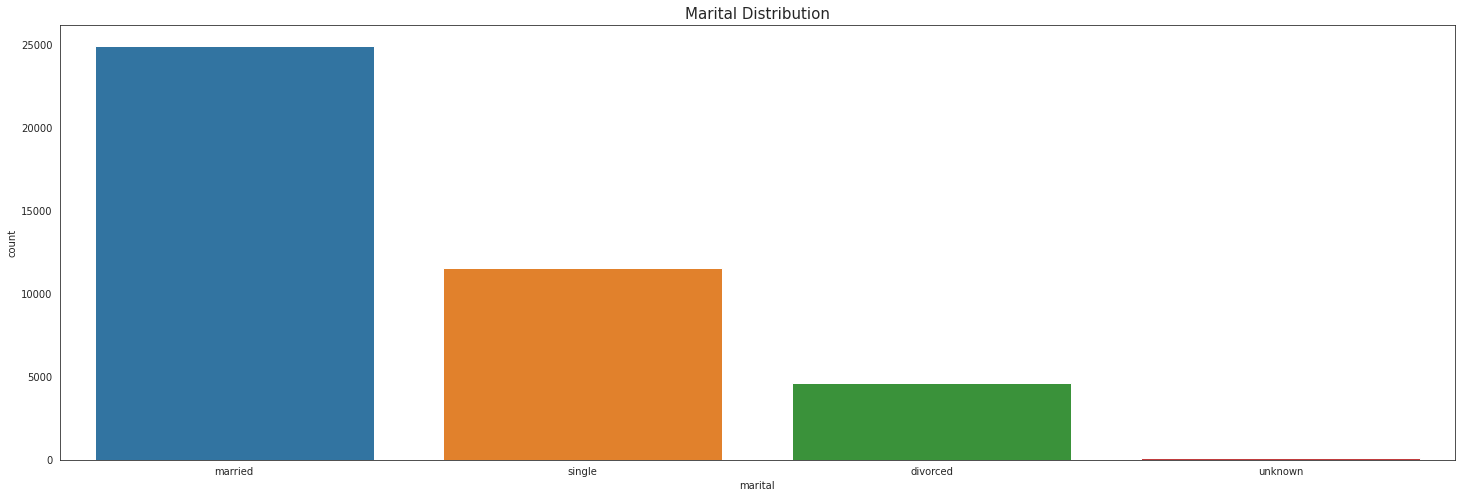

In [225]:
# marital distribution
fig, ax = plt.subplots()
fig.set_size_inches(25, 8)
sns.countplot(x='marital', data=client)
ax.set_title('Marital Distribution', fontsize=15)

print('Number of unknown marital status: ', len(client[client['marital'] == 'unknown']))

Number of unknown marital status:  18


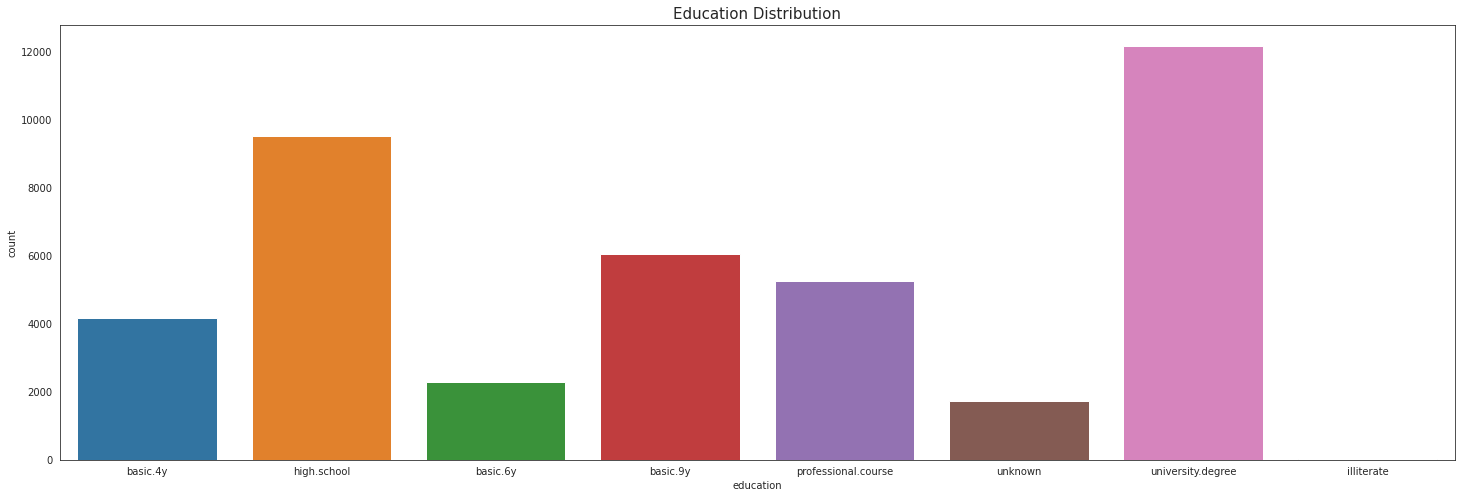

In [226]:
# education distribution
fig, ax = plt.subplots()
fig.set_size_inches(25, 8)
sns.countplot(x='education', data=client)
ax.set_title('Education Distribution', fontsize=15)

print('Number of unknown marital status: ', len(client[client['education'] == 'illiterate']))

Default data: 
Number of yes status:  3
Number of no status:  32588
Number of unknown status:  8597


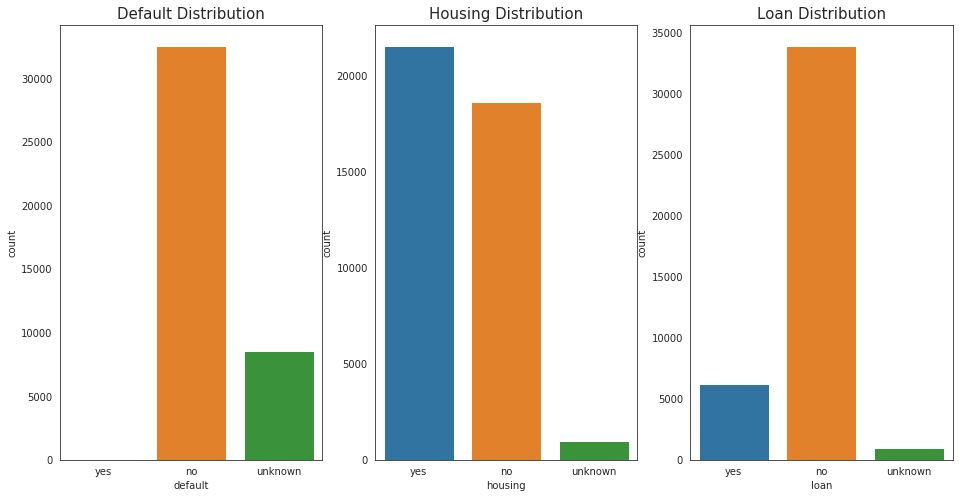

In [227]:
# default, housing, loan distribution

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (16, 8))

sns.countplot(x='default', data=client, ax=ax1, order = ['yes', 'no', 'unknown'])
ax1.set_title('Default Distribution', fontsize=15)

sns.countplot(x='housing', data=client, ax=ax2, order = ['yes', 'no', 'unknown'])
ax2.set_title('Housing Distribution', fontsize=15)

sns.countplot(x='loan', data=client, ax=ax3, order = ['yes', 'no', 'unknown'])
ax3.set_title('Loan Distribution', fontsize=15) 

print('Default data: ')
print('Number of yes status: ', len(client[client['default'] == 'yes']))
print('Number of no status: ', len(client[client['default'] == 'no']))
print('Number of unknown status: ', len(client[client['default'] == 'unknown']))

It appears that job, marital and education status have widely ranging categories, and may prove very useful for y outcome prediction. However, the default attribute may not show much promise in a predictive model. Again, it is too early to tell how both the default and age attributes play a role in the model, and it is best to just keep this information in the back of our minds. 

## Phone call day, using last_campaign dataframe

Text(0.5, 1.0, 'Day of Week Distribution')

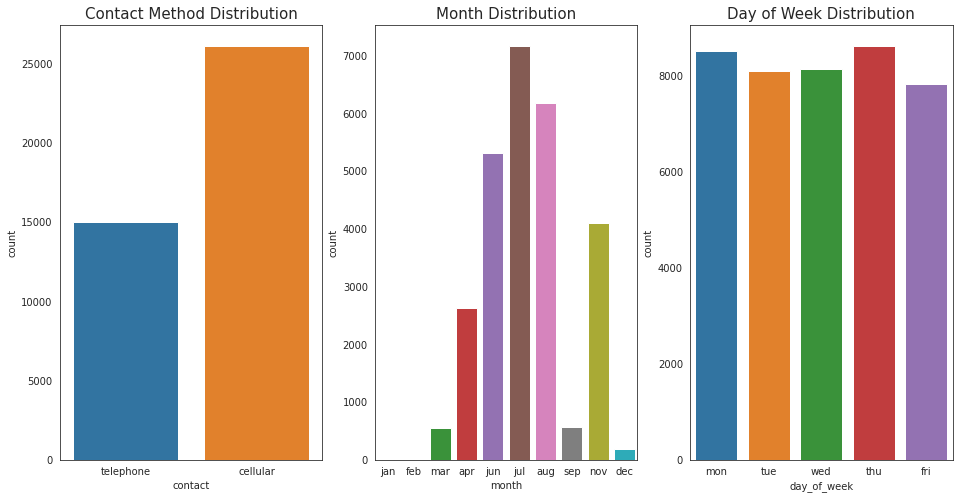

In [228]:
# contact, month, day_of_week distribution

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (16, 8))

sns.countplot(x='contact', data=last_campaign, ax=ax1)
ax1.set_title('Contact Method Distribution', fontsize=15)

sns.countplot(x='month', data=last_campaign, ax=ax2, order = ['jan', 'feb', 'mar', 'apr', 'jun', 'jul', 'aug', 'sep', 'nov', 'dec'])
ax2.set_title('Month Distribution', fontsize=15)

sns.countplot(x='day_of_week', data=last_campaign, ax=ax3, order = ['mon', 'tue', 'wed', 'thu', 'fri'])
ax3.set_title('Day of Week Distribution', fontsize=15) 

## Phone call day, using se dataframe
I wanted to see if the socioeconomic attributes were correlated to month. 

In [229]:
group = se.groupby('month')

print('data for emp.var.rate')
se_emp_var = group.apply(lambda x: x['emp.var.rate'].unique())
se_emp_var = se_emp_var.reindex(['jan', 'feb', 'mar', 'apr', 'jun', 'jul', 'aug', 'sep', 'nov', 'dec'])
print(se_emp_var)

print('\ndata for cons.price.idx')
se_cons_price = group.apply(lambda x: x['cons.price.idx'].unique())
se_cons_price = se_cons_price.reindex(['jan', 'feb', 'mar', 'apr', 'jun', 'jul', 'aug', 'sep', 'nov', 'dec'])
print(se_cons_price)

print('\ndata for cons.conf.idx')
se_cons_conf = group.apply(lambda x: x['cons.conf.idx'].unique())
se_cons_conf = se_cons_conf.reindex(['jan', 'feb', 'mar', 'apr', 'jun', 'jul', 'aug', 'sep', 'nov', 'dec'])
print(se_cons_conf)

data for emp.var.rate
month
jan                   NaN
feb                   NaN
mar                [-1.8]
apr                [-1.8]
jun     [1.4, -2.9, -1.7]
jul     [1.4, -2.9, -1.7]
aug     [1.4, -2.9, -1.7]
sep          [-3.4, -1.1]
nov    [-0.1, -3.4, -1.1]
dec          [-0.2, -3.0]
dtype: object

data for cons.price.idx
month
jan                                    NaN
feb                                    NaN
mar            [92.84299999999999, 93.369]
apr                       [93.075, 93.749]
jun               [94.465, 92.963, 94.055]
jul    [93.91799999999999, 92.469, 94.215]
aug    [93.444, 92.20100000000001, 94.027]
sep            [92.37899999999999, 94.199]
nov      [93.2, 92.649, 94.76700000000001]
dec                       [92.756, 92.713]
dtype: object

data for cons.conf.idx
month
jan                      NaN
feb                      NaN
mar           [-50.0, -34.8]
apr           [-47.1, -34.6]
jun    [-41.8, -40.8, -39.8]
jul    [-42.7, -33.6, -40.3]
aug    [-36.1, -31.

It appears that this data spans across multiple years, given the fact that some of the months have more datapoints than others. For example, 'cons.conf.idx' should be a monthly indicator, and some months have more values than others. A quick look at the raw data shows that the months are written in time order, and get looped back to march (the first month) somewhere in the middle of the csv file. As a result, it may not be fruitful to search for economic attribute correlations with month, as we are not given the year that these phone calls were made. 

## Other attributes, using other dataframe

In [230]:
for col in other: 
  print(other[col].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]
[999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]
[0 1 2 3 4 5 6 7]
['nonexistent' 'failure' 'success']


Looking at these values, graphing these values would not be very interesting. I chose not to here. 

# Data Augmentation

Transforming data into dummy variables

In [231]:
# dummy variables for client have been created -- dummy_client last_campaign, other, se
dummy_campaign = pd.get_dummies(last_campaign)
dummy_other = pd.get_dummies(other)
dummy_se = pd.get_dummies(se)
dummy_se = dummy_se.iloc[:, 0:5]

# final dummy variable dataset
dumdf = pd.concat([dummy_client, dummy_campaign, dummy_other, dummy_se], axis=1)

# check that no data was lost 
print(df.columns.values)
print(dumdf.head())

['age' 'job' 'marital' 'education' 'default' 'housing' 'loan' 'contact'
 'month' 'day_of_week' 'campaign' 'pdays' 'previous' 'poutcome'
 'emp.var.rate' 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed'
 'y']
   age  job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0   56           0                0                 0              1   
1   57           0                0                 0              0   
2   37           0                0                 0              0   
3   40           1                0                 0              0   
4   56           0                0                 0              0   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0               0            0                  0             0            0   
1               0            0                  0             1            0   
2               0            0                  0             1            0   
3               0            0

In [232]:
# extracting target variable
y = df.iloc[:, -1]
print(y)

0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 41188, dtype: object


### Splitting data into testing and training

In [233]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dumdf, y, test_size=0.3, random_state=42, stratify=y)

# Choosing and Building Models
The target variable here is binary. I will be testing out popular binary classifiers, including: 
* Logistic Regression
* Decision Trees
* Support Vector Machine
* Naive Bayes
* XGBoost

### Logistic Regression

In [234]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Decision Trees

In [235]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)
y_pred_dtc = dt.predict(X_test)

### Support Vector Machine

In [236]:
from sklearn.svm import SVC

svc = SVC(kernel='sigmoid', probability=True)
svc.fit(X_train, y_train)
y_pred_svm = svc.predict(X_test)

### Naive Bayes

https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

In [237]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB() 
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

### XGBoost

In [238]:
import xgboost as xgb 

# replace outcome with numerical variables 
y = y.replace(to_replace='no', value=0)
y = y.replace(to_replace='yes', value=1)

print(y) # 0=no, 1=yes

# create DMatrix datastructure 
data_dmatrix = xgb.DMatrix(data=dumdf,label=y)

# create XGBoost model 
xg = xgb.XGBClassifier(objective ='binary:logistic')

xg.fit(X_train,y_train)

y_pred_xgb = xg.predict(X_test)

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64


### Accuracy of Models

In [239]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

acc_lr = metrics.accuracy_score(y_pred_lr, y_test)
print("Accuracy on Logistic Regression Classifier:",acc_lr)

acc_dtc = metrics.accuracy_score(y_pred_dtc, y_test)
print("Accuracy on Decision Tree Classifier:",acc_dtc)

acc_svm = metrics.accuracy_score(y_pred_svm, y_test)
print("Accuracy on Support Vector Machine:", acc_svm)

acc_nb = metrics.accuracy_score(y_pred_nb, y_test)
print("Accuracy on Naive Bayes:", acc_nb)

acc_xgb = metrics.accuracy_score(y_pred_xgb, y_test)
print("Accuracy on XGBoost:", acc_xgb)

Accuracy on Logistic Regression Classifier: 0.8993283159342883
Accuracy on Decision Tree Classifier: 0.8442178522295055
Accuracy on Support Vector Machine: 0.8981953548595938
Accuracy on Naive Bayes: 0.8586226430363357
Accuracy on XGBoost: 0.9015133122926277


### Confusion Matrix of Models

In [240]:
print("Confusion Matrix on Logistic Regression Classifier:")
print(confusion_matrix(y_pred_lr, y_test))

print("Confusion Matrix on Decision Tree Classifier:")
print(confusion_matrix(y_pred_dtc, y_test))

print("Confusion Matrix on Support Vector Machine:")
print(confusion_matrix(y_pred_svm, y_test))

print("Confusion Matrix on Naive Bayes:")
print(confusion_matrix(y_pred_nb, y_test))

print("Confusion Matrix on XGBoost:")
print(confusion_matrix(y_pred_xgb, y_test))

Confusion Matrix on Logistic Regression Classifier:
[[10789  1068]
 [  176   324]]
Confusion Matrix on Decision Tree Classifier:
[[9935  895]
 [1030  497]]
Confusion Matrix on Support Vector Machine:
[[10823  1116]
 [  142   276]]
Confusion Matrix on Naive Bayes:
[[9961  743]
 [1004  649]]
Confusion Matrix on XGBoost:
[[10834  1086]
 [  131   306]]


Based upon these model results, I think the classifier that has the highest promise is the XGBoost model. Not only does it have the highest baseline accuracy, but it also has the lowest rates of false negatives and false positives. The best way to confirm this is to look at ROC and AUC. 

In [241]:
from sklearn import metrics

# change y_test values to 0 and 1
y_test_new = y_test.replace(to_replace='no', value=0)
y_test_new = y_test_new.replace(to_replace='yes', value=1)
print(y_test)
print(y_test_new)

# Logistic ROC/AUC
prob = lr.predict_proba(X_test)
pred = prob[:,1]
flr, tlr, thlr = metrics.roc_curve(y_test_new, pred)

# Decision Trees ROC/AUC
prob = dt.predict_proba(X_test)
pred = prob[:,1]
fdt, tdt, thdt = metrics.roc_curve(y_test_new, pred)

# Support Vector Machine ROC/AUC
prob = svc.predict_proba(X_test)
pred = prob[:,1]
fsvm, tsvm, thsvm = metrics.roc_curve(y_test_new, pred)

# Naive Bayes ROC/AUC
prob = nb.predict_proba(X_test)
pred = prob[:,1]
fnb, tnb, thnb = metrics.roc_curve(y_test_new, pred)

# XGBoost ROC/AUC
prob = xg.predict_proba(X_test)
pred = prob[:,1]
fxgb, txgb, thxgb = metrics.roc_curve(y_test_new, pred)

9923      no
3477      no
12077     no
1579      no
39993    yes
        ... 
18457     no
12561     no
20958     no
32448     no
1454      no
Name: y, Length: 12357, dtype: object
9923     0
3477     0
12077    0
1579     0
39993    1
        ..
18457    0
12561    0
20958    0
32448    0
1454     0
Name: y, Length: 12357, dtype: int64


Text(0.5, 1.0, 'ROC Comparison')

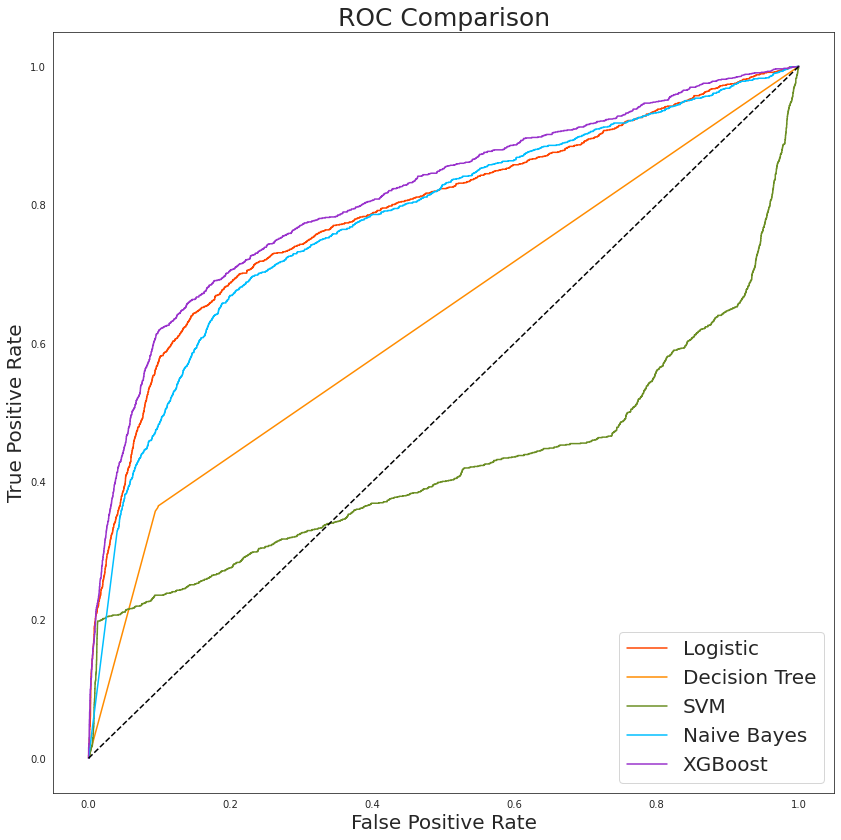

In [242]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 14)
ax.plot(flr, tlr, 'b', label = 'Logistic', color='orangered')
ax.plot(fdt, tdt, 'b', label = 'Decision Tree', color='darkorange')
ax.plot(fsvm, tsvm, 'b', label = 'SVM', color='olivedrab')
ax.plot(fnb, tnb, 'b', label = 'Naive Bayes', color='deepskyblue')
ax.plot(fxgb, txgb, 'b', label = 'XGBoost', color='darkorchid')
ax.plot([0, 1], [0, 1],'k--')
ax.legend(loc = 'lower right', prop={'size': 20})
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=20)
ax.set_title('ROC Comparison',fontsize=25)

The ROC Comparison graph reconfirms my hypothesis that XGBoost is the best model to use. 

# Refining XGBoost

Use cross validation to fine tune the model’s parameters such as alpha in lasso

Simplify your model using regularization, prunnning, drop-out, etc. to avoid overfitting

Communicate your model’s performance and make sure you compare it to a benchmark when appropriate

### Hyperparameter tuning for Cross Validation

In [243]:
# Number of trees to be used
n_estimators = [400, 600, 800, 1000, 1200, 1400]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, 3)]

# Learning rate
eta = [x for x in np.linspace(0.1, 0.5, 5)]

# Minimum loss reduction required to make further partition
gamma = [x for x in np.linspace(0, 0.6, 5)]

# colsamplee by tree
colsample = [0.7, 0.8, 0.9]

# Create the grid
xgb_grid = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'eta': eta,
            'gamma': gamma, 
            'colsample_bytree': colsample} 

print(xgb_grid)

{'n_estimators': [400, 600, 800, 1000, 1200, 1400], 'max_depth': [1, 5, 10], 'eta': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5], 'gamma': [0.0, 0.15, 0.3, 0.44999999999999996, 0.6], 'colsample_bytree': [0.7, 0.8, 0.9]}


In [244]:
from sklearn.model_selection import RandomizedSearchCV

# Create the model to be tuned
xgb_base = xgb.XGBClassifier(objective ='binary:logistic')

# Create the random search Random Forest
xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                cv = 3, verbose = 2,
                                random_state = 420, n_jobs = -1)

# Fit the random search model
xgb_random.fit(X_train, y_train)

# Get the optimal parameters
xgb_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.7min finished


{'colsample_bytree': 0.9,
 'eta': 0.4,
 'gamma': 0.3,
 'max_depth': 1,
 'n_estimators': 1000}

From this, we now know the optimal hyperparameters: 
* learning_rate = 0.4
* max_depth = 1, 
* colsample_bytree = 0.9 
* n_estimators = 1000, 
* gamma = 0.3

These hyperparameters will be used in the final model. 

### Comparing the baseline XGBoost model and the refined XGBoost model

In [245]:
# create baseline XGBoost model 
xg_base = xgb.XGBClassifier(objective='binary:logistic')
xg_base.fit(X_train, y_train)
y_pred_xg_base = xg_base.predict(X_test)

# create refined XGBoost model
xg_ref = xgb.XGBClassifier(objective ='binary:logistic', learning_rate=0.4, max_depth=1, colsample_bytree=0.9, n_estimators=1000, gamma=0.3)
xg_ref.fit(X_train,y_train)
y_pred_xgb_ref = xg_ref.predict(X_test)

In [246]:
# change y_test values to 0 and 1
y_pred_base_binary = np.where(y_pred_xg_base == 'no', 0, y_pred_xg_base)
y_pred_base_binary = np.where(y_pred_base_binary == 'yes', 1, y_pred_base_binary)

y_pred_ref_binary = np.where(y_pred_xgb_ref == 'no', 0, y_pred_xgb_ref)
y_pred_ref_binary = np.where(y_pred_ref_binary == 'yes', 1, y_pred_ref_binary)

'''
print(y_test)
print(y_test_new)
print(y_pred_xg_base)
print(y_pred_xgb_ref)
print(y_pred_base_binary)
print(y_pred_ref_binary)
'''

# Mean Absolute Error
mae_xgb = metrics.mean_absolute_error(y_pred_base_binary, y_test_new)
print('Mean Absolute Error on Baseline XGBoost:', mae_xgb)

mae_xgb_ref = metrics.mean_absolute_error(y_pred_ref_binary, y_test_new)
print('Mean Absolute Error on Refined XGBoost:', mae_xgb_ref)

# Mean Squared Error
print()
mse_xgb = metrics.mean_squared_error(y_pred_base_binary, y_test_new)
print('Mean Squared Error on Baseline XGBoost:', mse_xgb)

mse_xgb_ref = metrics.mean_squared_error(y_pred_ref_binary, y_test_new)
print('Mean Squared Error on Refined XGBoost:', mse_xgb_ref)

# R^2
print()
r2_xgb = metrics.r2_score(y_pred_base_binary, y_test_new)
print('R^2 Value on Baseline XGBoost:', r2_xgb)

r2_xgb_ref = metrics.r2_score(y_pred_ref_binary, y_test_new)
print('R^2 Value on Baseline XGBoost:', r2_xgb_ref)

# Accuracy Scores
print()
acc_xgb = metrics.accuracy_score(y_pred_xg_base, y_test)
print("Accuracy on Baseline XGBoost:", acc_xgb)

acc_xgb_ref = metrics.accuracy_score(y_pred_xgb_ref, y_test)
print("Accuracy on Refined XGBoost:", acc_xgb_ref)

# Classification Reports 
print()
class_xgb = metrics.classification_report(y_pred_xg_base, y_test)
print('Classification Report on Baseline XGBoost:\n', class_xgb)

class_xgb_ref = metrics.classification_report(y_pred_xgb_ref, y_test)
print('Classification Report on Refined XGBoost:\n', class_xgb_ref)


Mean Absolute Error on Baseline XGBoost: 0.09848668770737234
Mean Absolute Error on Refined XGBoost: 0.09808205875212431

Mean Squared Error on Baseline XGBoost: 0.09848668770737234
Mean Squared Error on Refined XGBoost: 0.09808205875212431

R^2 Value on Baseline XGBoost: -1.8869943406078673
R^2 Value on Baseline XGBoost: -1.8438019683162965

Accuracy on Baseline XGBoost: 0.9015133122926277
Accuracy on Refined XGBoost: 0.9019179412478757

Classification Report on Baseline XGBoost:
               precision    recall  f1-score   support

          no       0.99      0.91      0.95     11920
         yes       0.22      0.70      0.33       437

    accuracy                           0.90     12357
   macro avg       0.60      0.80      0.64     12357
weighted avg       0.96      0.90      0.93     12357

Classification Report on Refined XGBoost:
               precision    recall  f1-score   support

          no       0.99      0.91      0.95     11915
         yes       0.22      0.70 

From these results, we see that the baseline XGBoost model performs quite well, even in comparison to the refined model that accounts for overfitting (from learning_rate/eta, colsample_bytree) and employs regularization (from gamma). 

In order to improve the model's performance further, we could try to find out which parameters within the dataset are the most predictive, and give them larger weights. 